In [1]:
import os
import pathlib
import functools
from datetime import datetime

import numpy as np
import SimpleITK as sitk

import tensorflow as tf
from tensorflow.data.experimental import AutoShardPolicy

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from matplotlib import pyplot as plt


In [2]:
# Disable tensorflow warnings, shown in jupyter notebook.
tf.get_logger().setLevel('WARNING')

session = datetime.now().strftime("%Y%m%d-%H%M%S")
basedir = pathlib.Path('.').resolve()
distdir = basedir / 'dist' / session
runtime = basedir / 'runtime' / session
dataset = basedir / 'datasets' / 'COVID19'

In [3]:
@functools.lru_cache(maxsize=20)
def niiopen(fp) -> sitk.Image:
    image = sitk.ReadImage(fp, imageIO="NiftiImageIO")
    image = sitk.Cast(image, sitk.sitkFloat32)
    
    return image

In [4]:
def windowize_factory(wl, ww):
    """Creates а function that will rescale input image values
    to range from 0.0 to 1.0.
    """
    wl -= 0.5
    ww -= 1.0
    
    windowizer = sitk.IntensityWindowingImageFilter()
    windowizer.SetOutputMinimum(0.0)
    windowizer.SetOutputMaximum(1.0)
    windowizer.SetWindowMinimum(wl-(ww/2))
    windowizer.SetWindowMaximum(wl+(ww/2))
    
    def windowize(image: sitk.Image):
        return windowizer.Execute(image)
    
    return windowize


In [5]:
def resampler_factory(out_spacing=None, out_size=None, interpolator=sitk.sitkLinear):
    transform = sitk.Transform()
    resampler = sitk.ResampleImageFilter()
    resampler.SetTransform(transform)
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0.0)
    
    def resample(image: sitk.Image):
        inputs_size = np.asarray(image.GetSize(), dtype='uint16')
        inputs_spacing = np.asarray(image.GetSpacing(), dtype='float32')
        # Direciton cosine matrix of input image.
        inputs_dcm = np.asarray(image.GetDirection(), dtype='float32')
        inputs_dcm = np.reshape(inputs_dcm, (image.GetDimension(), -1))
        # Imput image origin and center
        inputs_origin = np.asarray(image.GetOrigin(), 'float32')
        inputs_center = np.matmul(inputs_dcm, (inputs_size - 1.0) / 2.0 * inputs_spacing)
        
        ##
        # Calculate output size.
        ##
        if out_size:
            (w, h, *_), d = out_size, inputs_size[2]
            output_size = np.asarray((w, h, d), 'uint16')
        else:
            output_size = inputs_size
        
        resampler.SetSize(output_size.tolist())
        
        ##
        # Calculate output spacing.
        ##
        if out_spacing:
            (x, y, *_), z = out_spacing, inputs_spacing[2]
            output_spacing = np.asarray((x, y, z), dtype='float32')
        else:
            output_spacing = inputs_spacing * (inputs_size / output_size)
        
        resampler.SetOutputSpacing(output_spacing.tolist())
        
        # Calculate output image center and origin.
        output_center = np.matmul(inputs_dcm, (output_size - 1.0) / 2.0 * output_spacing)
        output_origin = inputs_origin + (inputs_center - output_center)

        resampler.SetOutputOrigin(output_origin.tolist())
        resampler.SetOutputDirection(inputs_dcm.reshape(-1).tolist())

        return resampler.Execute(image)
    
    return resample


def resample_as(image: sitk.Image, reference: sitk.Image, interpolator=sitk.sitkLinear):
    """Helper function that resamples the image to parameters as reference image has."""
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0.0)
    
    return resampler.Execute(image)


In [6]:
batch_size = 8
files_tplt = 'coronacases_{:03d}.nii.gz'

inputs_path = dataset / 'cases'
labels_path = dataset / 'masks' / 'lungs_and_infection'

inputs_windowize = windowize_factory(-500, 1500)
# Create resamplers: the first one resizes the input image to defined size and spacing, and 
# the second one resamples labels (mask) as a reference (input) image.
inputs_resampler = resampler_factory((1.5, 1.5), (256, 256), interpolator=sitk.sitkLinear)
labels_resampler = functools.partial(resample_as, interpolator=sitk.sitkNearestNeighbor)

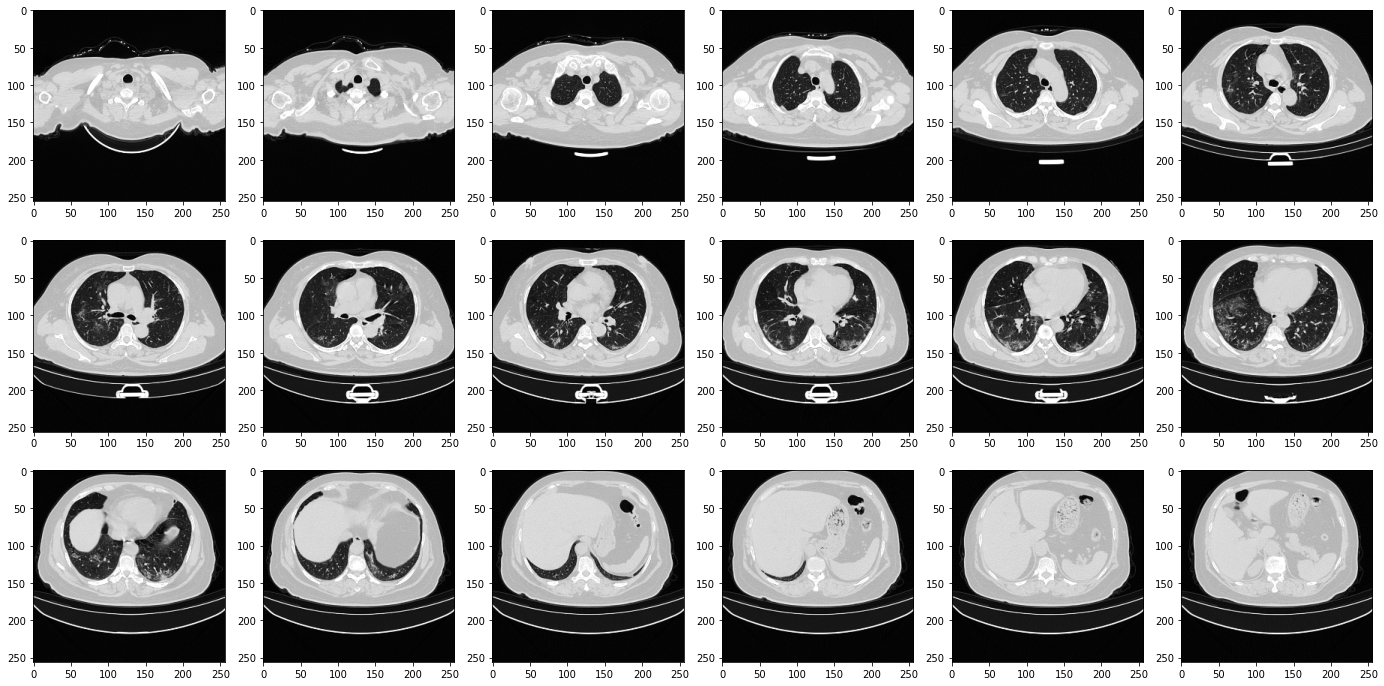

In [7]:
def plot_demo(arr: np.ndarray):
    ncols = 6
    nrows = -(-arr.shape[0] // ncols)
    
    fig, ax = plt.subplots(nrows, ncols, figsize=4 * np.array([ncols, nrows]))
    for i, a in enumerate(arr):
        ncol = i // ncols
        nrow = i - (ncols * ncol)
        ax[ncol, nrow].imshow(a, cmap='gray')
    plt.show()


demo_img = niiopen(fp=str(inputs_path / files_tplt.format(1)))
demo_img = inputs_windowize(demo_img)
demo_img = inputs_resampler(demo_img)

demo_arr = sitk.GetArrayFromImage(demo_img)
demo_arr = np.rot90(demo_arr[30:300:15], 2)

plot_demo(demo_arr)

In [8]:
inputs_dtype = np.float32
inputs_shape = (256, 256, 1)

labels_dtype = np.float32
labels_shape = (256, 256, 4)


def make_dataset(filenames):
    def inputs():
        for filename in filenames:
            inputs = niiopen(fp=str(inputs_path / filename))
            inputs = inputs_windowize(inputs)
            inputs = inputs_resampler(inputs)
            
            labels = niiopen(fp=str(labels_path / filename))
            labels = labels_resampler(labels, inputs)
            
            for x, y in zip(cast_inputs(inputs), cast_labels(labels)):
                # if np.all(y[..., 0] == 1.):
                #     continue
                yield np.rot90(x, 2), np.rot90(y, 2)

    dtypes = inputs_dtype, labels_dtype
    shapes = inputs_shape, labels_shape

    return tf.data.Dataset.from_generator(inputs, dtypes, shapes)


def cast_inputs(inputs: sitk.Image):
    """Prepares CT scans. The input image MUST be scaled to Hounsfield
    Units (HU) to perform windowing operations."""
    width, height, depth = inputs.GetSize()
    
    for array in sitk.GetArrayFromImage(inputs):
        output = np.zeros((width, height, 1), np.float32)
        output[..., 0] = array
        yield output

        
def cast_labels(labels: sitk.Image):
    """Preforms a one-hot-encode for labels. Contributions are labeling
    left lung (1), right lung (2) in each CT scan."""
    width, height, depth = labels.GetSize()
    
    for array in sitk.GetArrayFromImage(labels):
        output = np.zeros((width, height, 4), np.float32)
        np.place(output[..., 0], array == 0., 1.)  # Backgrounds
        np.place(output[..., 1], array == 1., 1.)  # Lung (L)
        np.place(output[..., 2], array == 2., 1.)  # Lung (R)
        np.place(output[..., 3], array == 3., 1.)  # COVID-19
        yield output
        

In [9]:
# Create a training dataset (001-008) and validation one (009-010).
fit_dataset = make_dataset([files_tplt.format(i) for i in range(1,  9)])
val_dataset = make_dataset([files_tplt.format(i) for i in range(9, 11)])


In [10]:
def unet_v1(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = UpSampling2D(size=(2,2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2,2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=(2,2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = UpSampling2D(size=(2,2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Per-pixel classification layer.
    outputs = Conv2D(4, (1, 1), activation='softmax', dtype=tf.float32)(conv9)

    return Model(inputs, outputs)

In [11]:
def bcdu_net_d3(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_1)
    conv4_1 = Dropout(0.1)(conv4_1)

    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_1)     
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)
    conv4_2 = Dropout(0.1)(conv4_2)
    
    merge_dense = concatenate([conv4_1, conv4_2], axis=3)
    
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
   
    up5 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(drop4_3)
    up5 = BatchNormalization(axis=3)(up5)
    up5 = Activation('relu')(up5)

    x1 = Reshape(target_shape=(1, np.int32(input_size[0]/4), np.int32(input_size[0]/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(input_size[0]/4), np.int32(input_size[0]/4), 256))(up5)
    merge5 = concatenate([x1, x2], axis=1) 
    merge5 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal' )(merge5)

    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv5)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(input_size[0]/2), np.int32(input_size[0]/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(input_size[0]/2), np.int32(input_size[0]/2), 128))(up6)
    merge6 = concatenate([x1, x2], axis=1) 
    merge6 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal')(merge6)
        
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)    

    x1 = Reshape(target_shape=(1, input_size[0], input_size[0], 64))(conv1)
    x2 = Reshape(target_shape=(1, input_size[0], input_size[0], 64))(up7)
    merge7 = concatenate([x1, x2], axis=1) 
    merge7 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal')(merge7)    
    
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Per-pixel classification layer.
    outputs = Conv2D(4, (1, 1), activation='softmax', dtype='float32')(conv7)

    return Model(inputs, outputs)

In [12]:
def bcdu_net_d3_v2(input_size=(256, 256, 1)):
    inputs, (W, H, D) = Input(input_size), input_size

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_1)
    #conv5_1 = Dropout(0.5)(conv5_1)

    conv5_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_1)
    conv5_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_2)
    #conv5_2 = Dropout(0.5)(conv5_2)

    merge_dense = concatenate([conv5_1, conv5_2], axis=3)
    
    conv5_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)
    conv5_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_3)
    drop5_3 = Dropout(0.5)(conv5_3)

    up6 = Conv2DTranspose(512, 2, strides=2, padding='same', kernel_initializer='he_normal')(drop5_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)
    
    x1 = Reshape((1, np.int32(W/8), np.int32(H/8), 512))(drop4)
    x2 = Reshape((1, np.int32(W/8), np.int32(H/8), 512))(up6)
    merge6 = concatenate([x1, x2], axis=1)
    merge6 = ConvLSTM2D(256, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge6)
    
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)
    
    x1 = Reshape((1, np.int32(W/4), np.int32(H/4), 256))(conv3)
    x2 = Reshape((1, np.int32(W/4), np.int32(H/4), 256))(up7)
    merge7 = concatenate([x1, x2], axis=1)
    merge7 = ConvLSTM2D(128, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge7)
    
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)
    
    x1 = Reshape((1, np.int32(W/2), np.int32(H/2), 128))(conv2)
    x2 = Reshape((1, np.int32(W/2), np.int32(H/2), 128))(up8)
    merge8 = concatenate([x1, x2], axis=1)
    merge8 = ConvLSTM2D(64, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge8)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv8)
    up9 = BatchNormalization(axis=3)(up9)
    up9 = Activation('relu')(up9)
    
    x1 = Reshape((1, W, H, 64))(conv1)
    x2 = Reshape((1, W, H, 64))(up9)
    merge9 = concatenate([x1, x2], axis=1)
    merge9 = ConvLSTM2D(32, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge9)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Per-pixel classification layer.
    outputs = Conv2D(4, (1, 1), activation='softmax', dtype='float32')(conv9)

    return Model(inputs, outputs, name='bcdu_net_d3')

In [13]:
def create_jac(class_weights):
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    
    class_weights = tf.cast(class_weights, tf.float32)
    
    def w_jac(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """The Jaccard coefficient measures similarity between finite
        sample sets, and is defined as the size of the intersection
        divided by the size of the union of the sample sets.
        """
        # Calculate intersection between 2 sets.
        intersection = y_true * y_pred * class_weights
        intersection = K.sum(intersection, axis=[1, 2, 3])
        # Calculate the union of two sets.
        union = (y_true + y_pred - y_true * y_pred) * class_weights
        union = K.sum(union, axis=[1, 2, 3])
        
        return 1 - (intersection / union)
    
    return w_jac

In [14]:
def create_dsc(class_weights):
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    
    class_weights = tf.cast(class_weights, tf.float32)
    
    def w_dsc(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """ The Sørensen–Dice index equals twice the number of elements
        common to both sets (intersection) divided by the sum of the
        number of elements in each set.
        """
        # Calculate intersection between 2 sets.
        intersection = y_true * y_pred * class_weights
        intersection = K.sum(intersection, axis=[1, 2, 3])
        # The sum of the number of elements in each set. 
        denominator = (y_true + y_pred) * class_weights
        denominator = K.sum(denominator, axis=[1, 2, 3])
        
        return 1 - (2. * intersection / denominator)
    
    return w_dsc


In [15]:
from tensorflow.keras.activations import softmax
from typing import Callable, Union

def create_categorical_crossentropy(class_weights) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """Multi-class weighted cross entropy.
    
    Used as loss function for multi-class image segmentation
    with one-hot encoded masks.
    
            WCE(p, p̂) = −Σp*log(p̂) * class_weights
            
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    
    class_weights = tf.cast(class_weights, tf.float32)

    def w_categorical_crossentropy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        # Number of class_weights needs to be the same
        # as number of classes.
        assert len(class_weights) == y_pred.shape[-1]
        # Helps to avoid unwanted behaviour in K.log(y_pred)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        wce = y_true * K.log(y_pred) * class_weights
        wce = K.mean(wce, axis=[1, 2, 3])

        return -wce

    return w_categorical_crossentropy

In [16]:
def compute_class_weights(dataset: tf.data.Dataset):
    """Estimates class weights for unbalanced datasets."""
    labels = np.stack(arrays=list([y for _, y in dataset.as_numpy_iterator()]))
    labels = np.argmax(labels, axis=-1)
    
    unique, counts = np.unique(labels, return_counts=True)
    n_classes = len(unique)
    n_samples = sum(counts)
    
    return n_samples / (n_classes * counts)


In [17]:
# Free up RAM in case the model definition cells were
# run multiple times.
K.clear_session()

# Use half precision.
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# For training on multiple GPUs installed on a single machine.
strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
    # Note: the `tf.distribute.NcclAllReduce()` is not supported
    # on Windows 10.
)

with strategy.scope():
    class_weights = compute_class_weights(fit_dataset)
    class_weights = tf.constant(class_weights)
    # Create losses.
    jac = create_jac(class_weights)
    dsc = create_dsc(class_weights)
    wce = create_categorical_crossentropy(class_weights)
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model building & `compile()`.
    model = bcdu_net_d3_v2(input_size=(256, 256, 1))
    model.compile(optimizer=Adam(lr=1e-4), loss=jac, metrics=[wce, dsc])
    model.summary()


Model: "bcdu_net_d3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [18]:
model_ckpt_path = runtime / 'ckpts'
model_ckpt_name = 'ckpt-{epoch:02d}-{val_loss:.4f}'
model_ckpt = ModelCheckpoint(
    filepath=model_ckpt_path / model_ckpt_name,
    save_weights_only=True,
    save_best_only=False,
    monitor='val_loss',
    mode='min',
    verbose=0
)

# Ensure the parent directoy for checkpoints exists.
if not model_ckpt_path.exists():
    model_ckpt_path.mkdir(parents=True, exist_ok=True)


In [ ]:
XYt = fit_dataset.batch(batch_size)
XYv = val_dataset.batch(batch_size)

# Train the model on all available devices.
history = model.fit(XYt, validation_data=XYv, epochs=50, callbacks=[
    model_ckpt,
])

# Save model in tensorflow format.
model.save(distdir, save_format='tf')

Epoch 1/50
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
253/253 [==============================] - 92s 366ms/step - loss: 0.6608 - w_categorical_crossentropy: 2.3461 - w_dsc: 0.5618 - val_loss: 0.4979 - val_w_categorical_crossentropy: 2.1676 - val_w_dsc: 0.3999
Epoch 2/50
253/253 [==============================] - 88s 350ms/step - loss: 0.5826 - w_categorical_crossentropy: 3.0026 - w_dsc: 0.4778 - val_loss: 0.4975 - val_w_categorical_crossentropy: 2.2501 - val_w_dsc: 0.3997
Epoch 3/50
  9/253 [>.............................] - ETA: 1:09 - loss: 0.0358 - w_categorical_crossentropy: 0.0452 - w_dsc: 0.0196        

In [ ]:
# Plot training and validation loss.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['w_dsc'], label='Training')
plt.plot(history.history['val_w_dsc'], label='Validation')
plt.title('DSC')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
del model

K.clear_session()
model = load_model(distdir, custom_objects={'w_categorical_crossentropy': wce, 'w_jac': jac, 'w_dsc': dsc})
model.load_weights(model_ckpt_path / 'ckpt-50-0.0447')

In [ ]:
dcmreader = sitk.ImageSeriesReader()
dcmreader.SetImageIO("GDCMImageIO")

def dcmopen(fp) -> sitk.Image:
    filenames = dcmreader.GetGDCMSeriesFileNames(str(fp))
    dcmreader.SetFileNames(filenames)
    
    output = dcmreader.Execute()
    output = sitk.Cast(output, sitk.sitkFloat32)
    return output


series = dcmopen(basedir / 'datasets' / 'DICOM' / 'example-1')

img_x = inputs_windowize(series)
img_x = inputs_resampler(img_x)

def generate_inputs():
    for x in cast_inputs(img_x):
        yield x
        
x = tf.data.Dataset.from_generator(generate_inputs, inputs_dtype, inputs_shape)
y = model.predict(x.batch(batch_size))
y = to_categorical(np.argmax(y, axis=-1), num_classes=4)

img_y = sitk.GetImageFromArray(y)
img_y.CopyInformation(img_x)

result = resample_as(img_y, series)

In [ ]:
arr_x = sitk.GetArrayFromImage(series)
arr_y = sitk.GetArrayFromImage(result)


def plot_results(array0, array1):
    ncols = 4
    nrows = array0.shape[0]
    
    fig, ax = plt.subplots(nrows, ncols, figsize=4 * np.array([ncols, nrows]))
    for nrow, (arr0, arr1) in enumerate(zip(array0, array1)):
        ax[nrow, 0].imshow(arr0, cmap='gray')
        ax[nrow, 0].imshow(arr1[..., 3], cmap='hot', alpha=.25)
        ax[nrow, 1].imshow(arr1[..., 1], cmap='binary')
        ax[nrow, 2].imshow(arr1[..., 2], cmap='binary')
        ax[nrow, 3].imshow(arr1[..., 3], cmap='binary')
    plt.show()


plot_results(arr_x, arr_y)